# Threshold Calibration with counter mode

In [1]:
import matplotlib.pylab as plt
import pandas           as pd
import tables           as tb
import numpy            as np
import warnings
warnings.filterwarnings("ignore")

from matplotlib.dates import MINUTELY, SECONDLY
from matplotlib.dates import DateFormatter
from matplotlib.dates import rrulewrapper
from matplotlib.dates import RRuleLocator

from glob             import glob
from datetime         import datetime
from sklearn.cluster  import KMeans
from scipy.optimize   import curve_fit

In [2]:
import sys 
sys.path.append("/home/nsalor/Software/ANTEA")
sys.path.append("/home/nsalor/Software/IC")

In [3]:
from antea.preproc.io                    import get_files
from antea.preproc.io                    import get_evt_times
from antea.preproc.threshold_calibration import get_run_control
from antea.preproc.threshold_calibration import compute_limit_evts_based_on_run_control
from antea.preproc.threshold_calibration import filter_df_evts
from antea.preproc.threshold_calibration import process_df
from antea.preproc.threshold_calibration import compute_max_counter_value_for_each_config
from antea.preproc.threshold_calibration import plot_evts_recorded_per_configuration
from antea.preproc.threshold_calibration import plot_time_distribution
from antea.preproc.threshold_calibration import plot_channels
from antea.preproc.threshold_calibration import process_run
from antea.preproc.threshold_calibration import find_threshold

**Data to analyze**

In [4]:
field = 'vth_t1'   # It depends on the threshold we are calibrating: vth_t1 or vth_t2
expected_values = 63

In [27]:
run_number = 12317
tofpet_id  = 1

channels   = list(range(64))
nbits      = 22

In [6]:
df_data = pd.read_hdf(get_files(run_number)[0], 'counter')
df_data

,evt_number,card_id,tofpet_id,wordtype_id,reserved,channel_id,sensor_id,count
0,1,0,1,1,4096,0,115,0
1,2,0,1,1,4096,1,146,0
2,2,0,1,1,4096,2,116,0
3,2,0,1,1,4096,3,126,0
4,2,0,1,1,4096,4,125,0
...,...,...,...,...,...,...,...,...
384059,12004,0,1,1,8192,59,185,4194304
384060,12004,0,1,1,8192,60,188,4194304
384061,12004,0,1,1,8192,61,158,4194304
384062,12004,0,1,1,8192,62,178,4194304


In [7]:
df_data.tofpet_id.unique()

array([1], dtype=uint8)

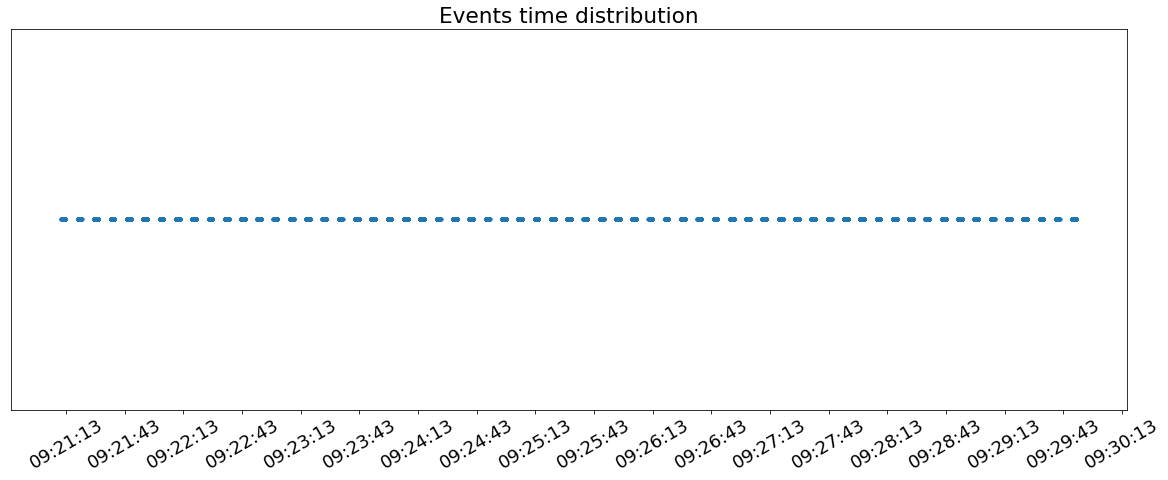

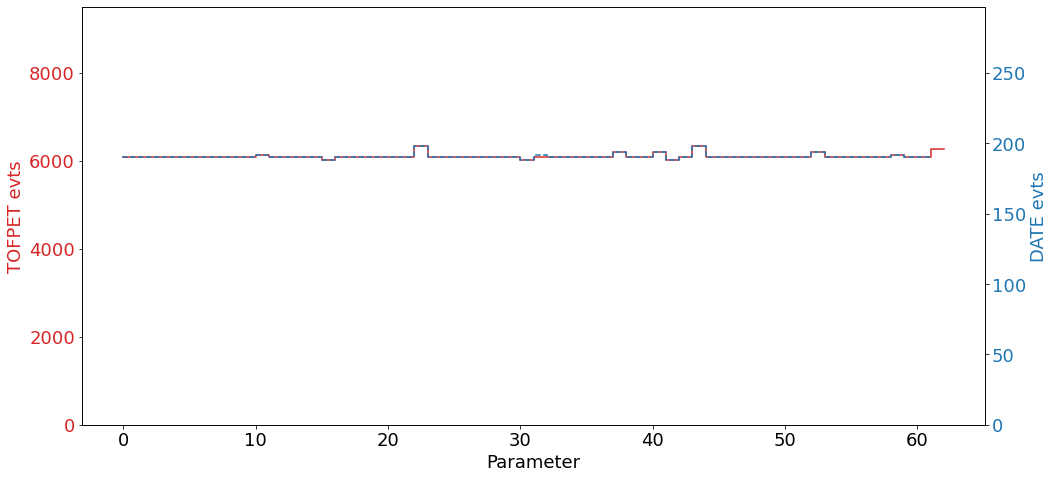

In [8]:
df_counts = process_run(run_number, nbits, field, tofpet_id, channels, plot=True)

**Add columns with data_time and expected_rate for vth_t2**

In [28]:
df_counts['data_time']     = (2**22 * 5) / 1e9 * df_counts['count']
df_counts['expected_rate'] = df_counts['sum'] / df_counts['data_time']

In [10]:
df_counts[(df_counts['channel_id'] == 60)][0:15]

,channel_id,count,mean,std,min,max,sum,vth_t1,data_time,expected_rate
60,60,95,0.000000,0.000000,0,0,0,0,1.992294,0.000000
60,60,95,0.000000,0.000000,0,0,0,1,1.992294,0.000000
60,60,95,0.000000,0.000000,0,0,0,2,1.992294,0.000000
60,60,95,0.000000,0.000000,0,0,0,3,1.992294,0.000000
60,60,95,0.000000,0.000000,0,0,0,4,1.992294,0.000000
60,60,95,0.000000,0.000000,0,0,0,5,1.992294,0.000000
60,60,95,0.000000,0.000000,0,0,0,6,1.992294,0.000000
60,60,95,0.000000,0.000000,0,0,0,7,1.992294,0.000000
60,60,95,0.010526,0.102598,0,1,1,8,1.992294,0.501934
60,60,95,0.000000,0.000000,0,0,0,9,1.992294,0.000000


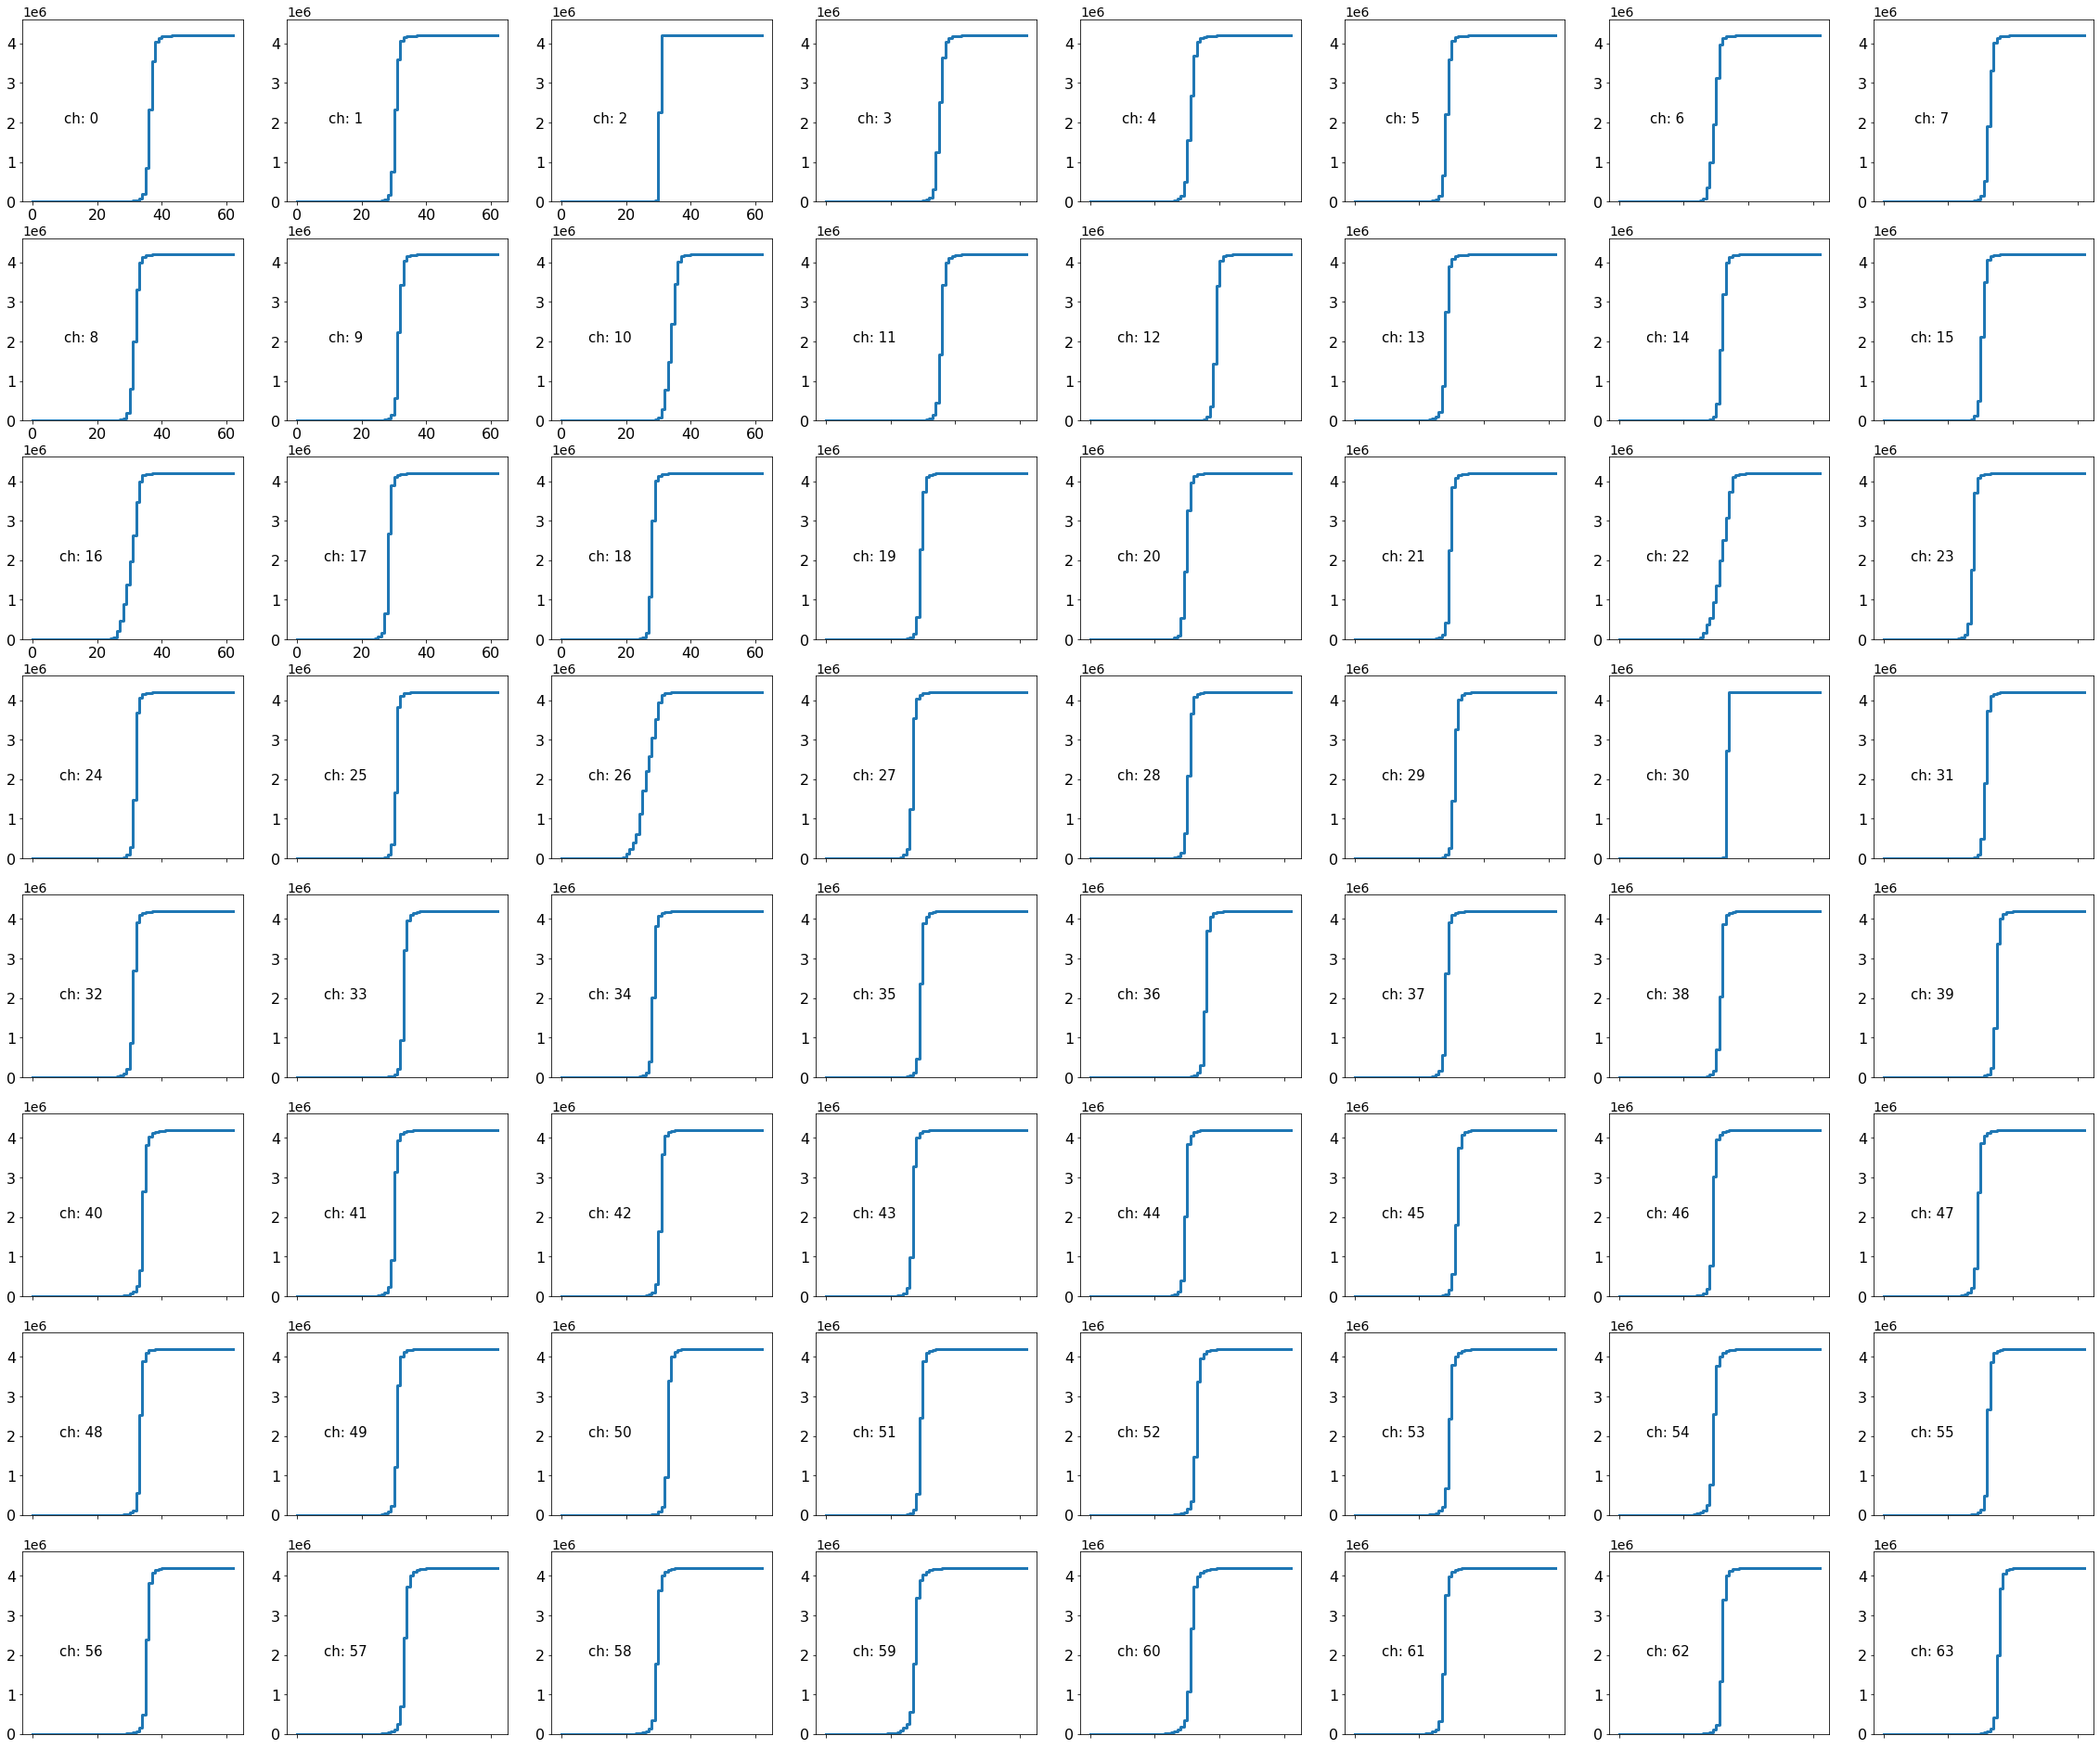

In [11]:
plot_channels(df_counts, channels, nbits)

# Compare several runs

In [26]:
runs       = {'nbits' : 22, 'asic' : 0, 'run_number' : [11808, 11956]}
field_comp = 'vth_t1'

In [13]:
channels = list(range(64))

In [14]:
def compare_runs(runs, field_comp, channels):
    dfs = []
    for run in runs['run_number']:
        df = process_run(run, runs['nbits'], field_comp, runs['asic'], channels, plot = True)
        dfs.append(df)
    return dfs

In [15]:
def plot_channels_multiple_runs(dfs, runs_dict, channels, title='', fname=None):
    '''
    It plots the channel count from different runs in the same subplot so that it is easier to compare them.
    '''
    runs = runs_dict['run_number']
    nbits = runs_dict['nbits']
    rows = int(len(channels)/8)
    
    #Plot size for different number of channels available
    if len(channels) == 64:
        fig, ax = plt.subplots(figsize=(40,34))
    
    elif len(channels) == 48:
        fig, ax = plt.subplots(figsize=(40,26))
        
    elif len(channels) == 32:
        fig, ax = plt.subplots(figsize=(40,17))    
        
    elif len(channels) == 16:
        fig, ax = plt.subplots(figsize=(40,8))    
    
    colors = iter(['red', 'blue', 'orange', 'green', 'brown', 'yellow'])
    
    for df_counts, run in zip(dfs, runs):
        color = next(colors)
        for i, ch in enumerate(channels):
            values = df_counts[df_counts.channel_id == ch]['max'].values
            ax     = plt.subplot(rows, 8, i+1)
            ymax   = (2**nbits)
            
            plt.plot(values, drawstyle='steps', linewidth=3, color=color, alpha=0.5, label=run)
            plt.ylim(0, 1.1*ymax)
            plt.text(5, 0.5*ymax, f"ch: {ch}", horizontalalignment='center', verticalalignment='center', rotation=0, fontsize=13)
            
            max_label = '2^{{{}}}'.format(nbits)
            ax.set_yticks([0, 2**nbits])
            ax.set_yticklabels(['$0$', f'${max_label}$'])
            plt.setp(ax.get_yticklabels(), fontsize=14)
            
            if i in [0, 1, 2, 8, 9, 10, 16, 17, 18]:
                plt.setp(ax.get_xticklabels(), fontsize=18)
            else:
                plt.setp(ax.get_xticklabels(), visible=False)
    
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(bbox_to_anchor=(1.5, rows + 1.3))
    plt.suptitle(title)
    fig.tight_layout()
    
    if fname:
        plt.savefig(fname)

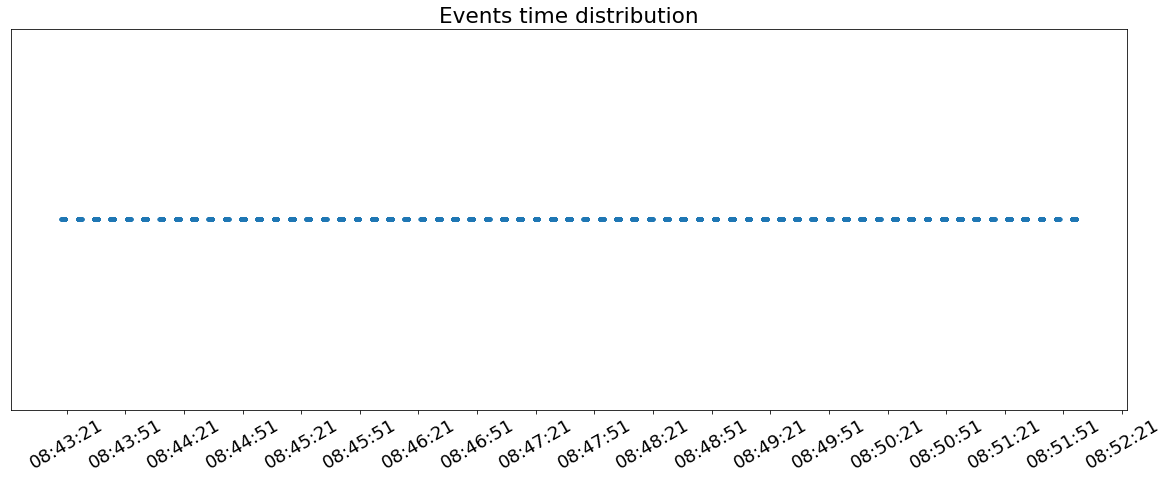

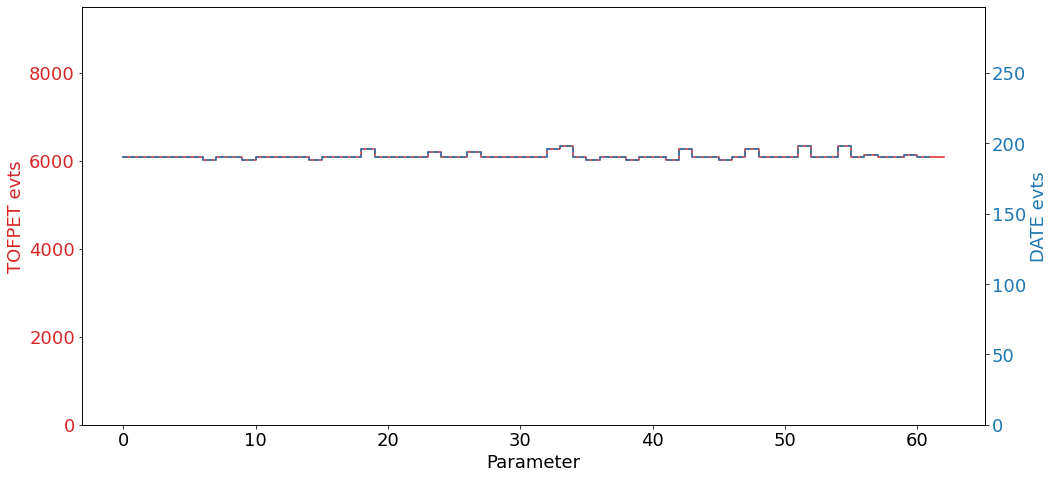

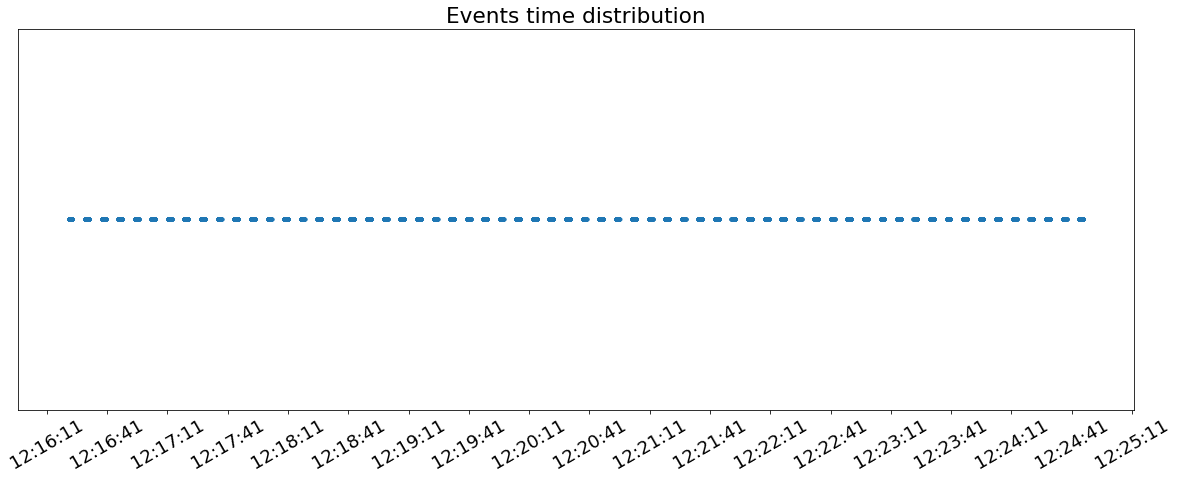

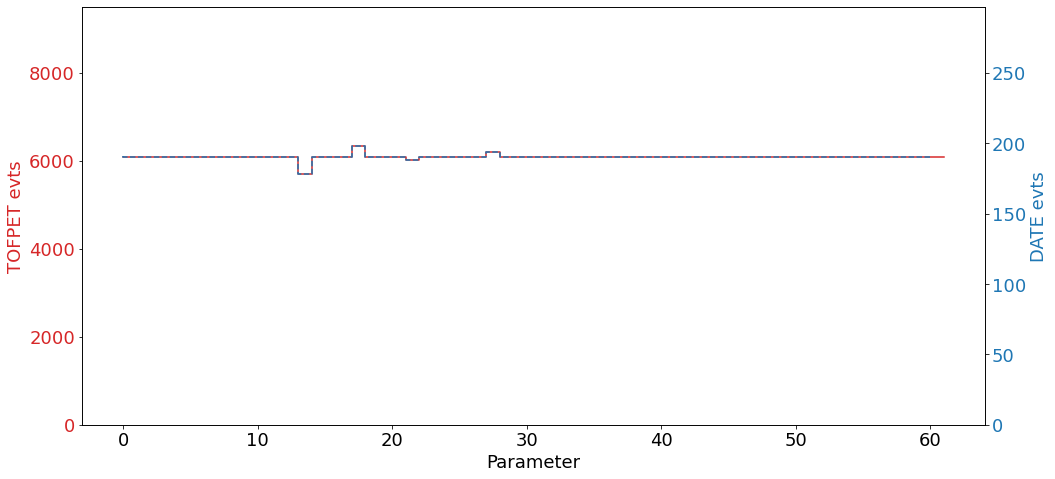

In [16]:
dfs = compare_runs(runs, field_comp, channels)

In [17]:
dfs

[    channel_id  count          mean       std      min      max        sum  \
 0            0     95  0.000000e+00  0.000000        0        0          0   
 1            1     95  0.000000e+00  0.000000        0        0          0   
 2            2     95  0.000000e+00  0.000000        0        0          0   
 3            3     95  0.000000e+00  0.000000        0        0          0   
 4            4     95  0.000000e+00  0.000000        0        0          0   
 ..         ...    ...           ...       ...      ...      ...        ...   
 59          59     95  4.194304e+06  0.410391  4194300  4194304  398458876   
 60          60     95  4.194304e+06  0.410391  4194300  4194304  398458876   
 61          61     95  4.194304e+06  0.410391  4194300  4194304  398458876   
 62          62     95  4.194304e+06  0.410391  4194300  4194304  398458876   
 63          63     95  4.194304e+06  0.410391  4194300  4194304  398458876   
 
     vth_t1  
 0        0  
 1        0  
 2      

**Add columns with data_time and expected_rate for vth_t2**

In [18]:
dfs[0]['data_time'] = (2**22 * 5) / 1e9 * dfs[0]['count']
dfs[0]['expected_rate'] = dfs[0]['sum'] / dfs[0]['data_time']

dfs[1]['data_time'] = (2**22 * 5) / 1e9 * dfs[1]['count']
dfs[1]['expected_rate'] = dfs[1]['sum'] / dfs[1]['data_time']

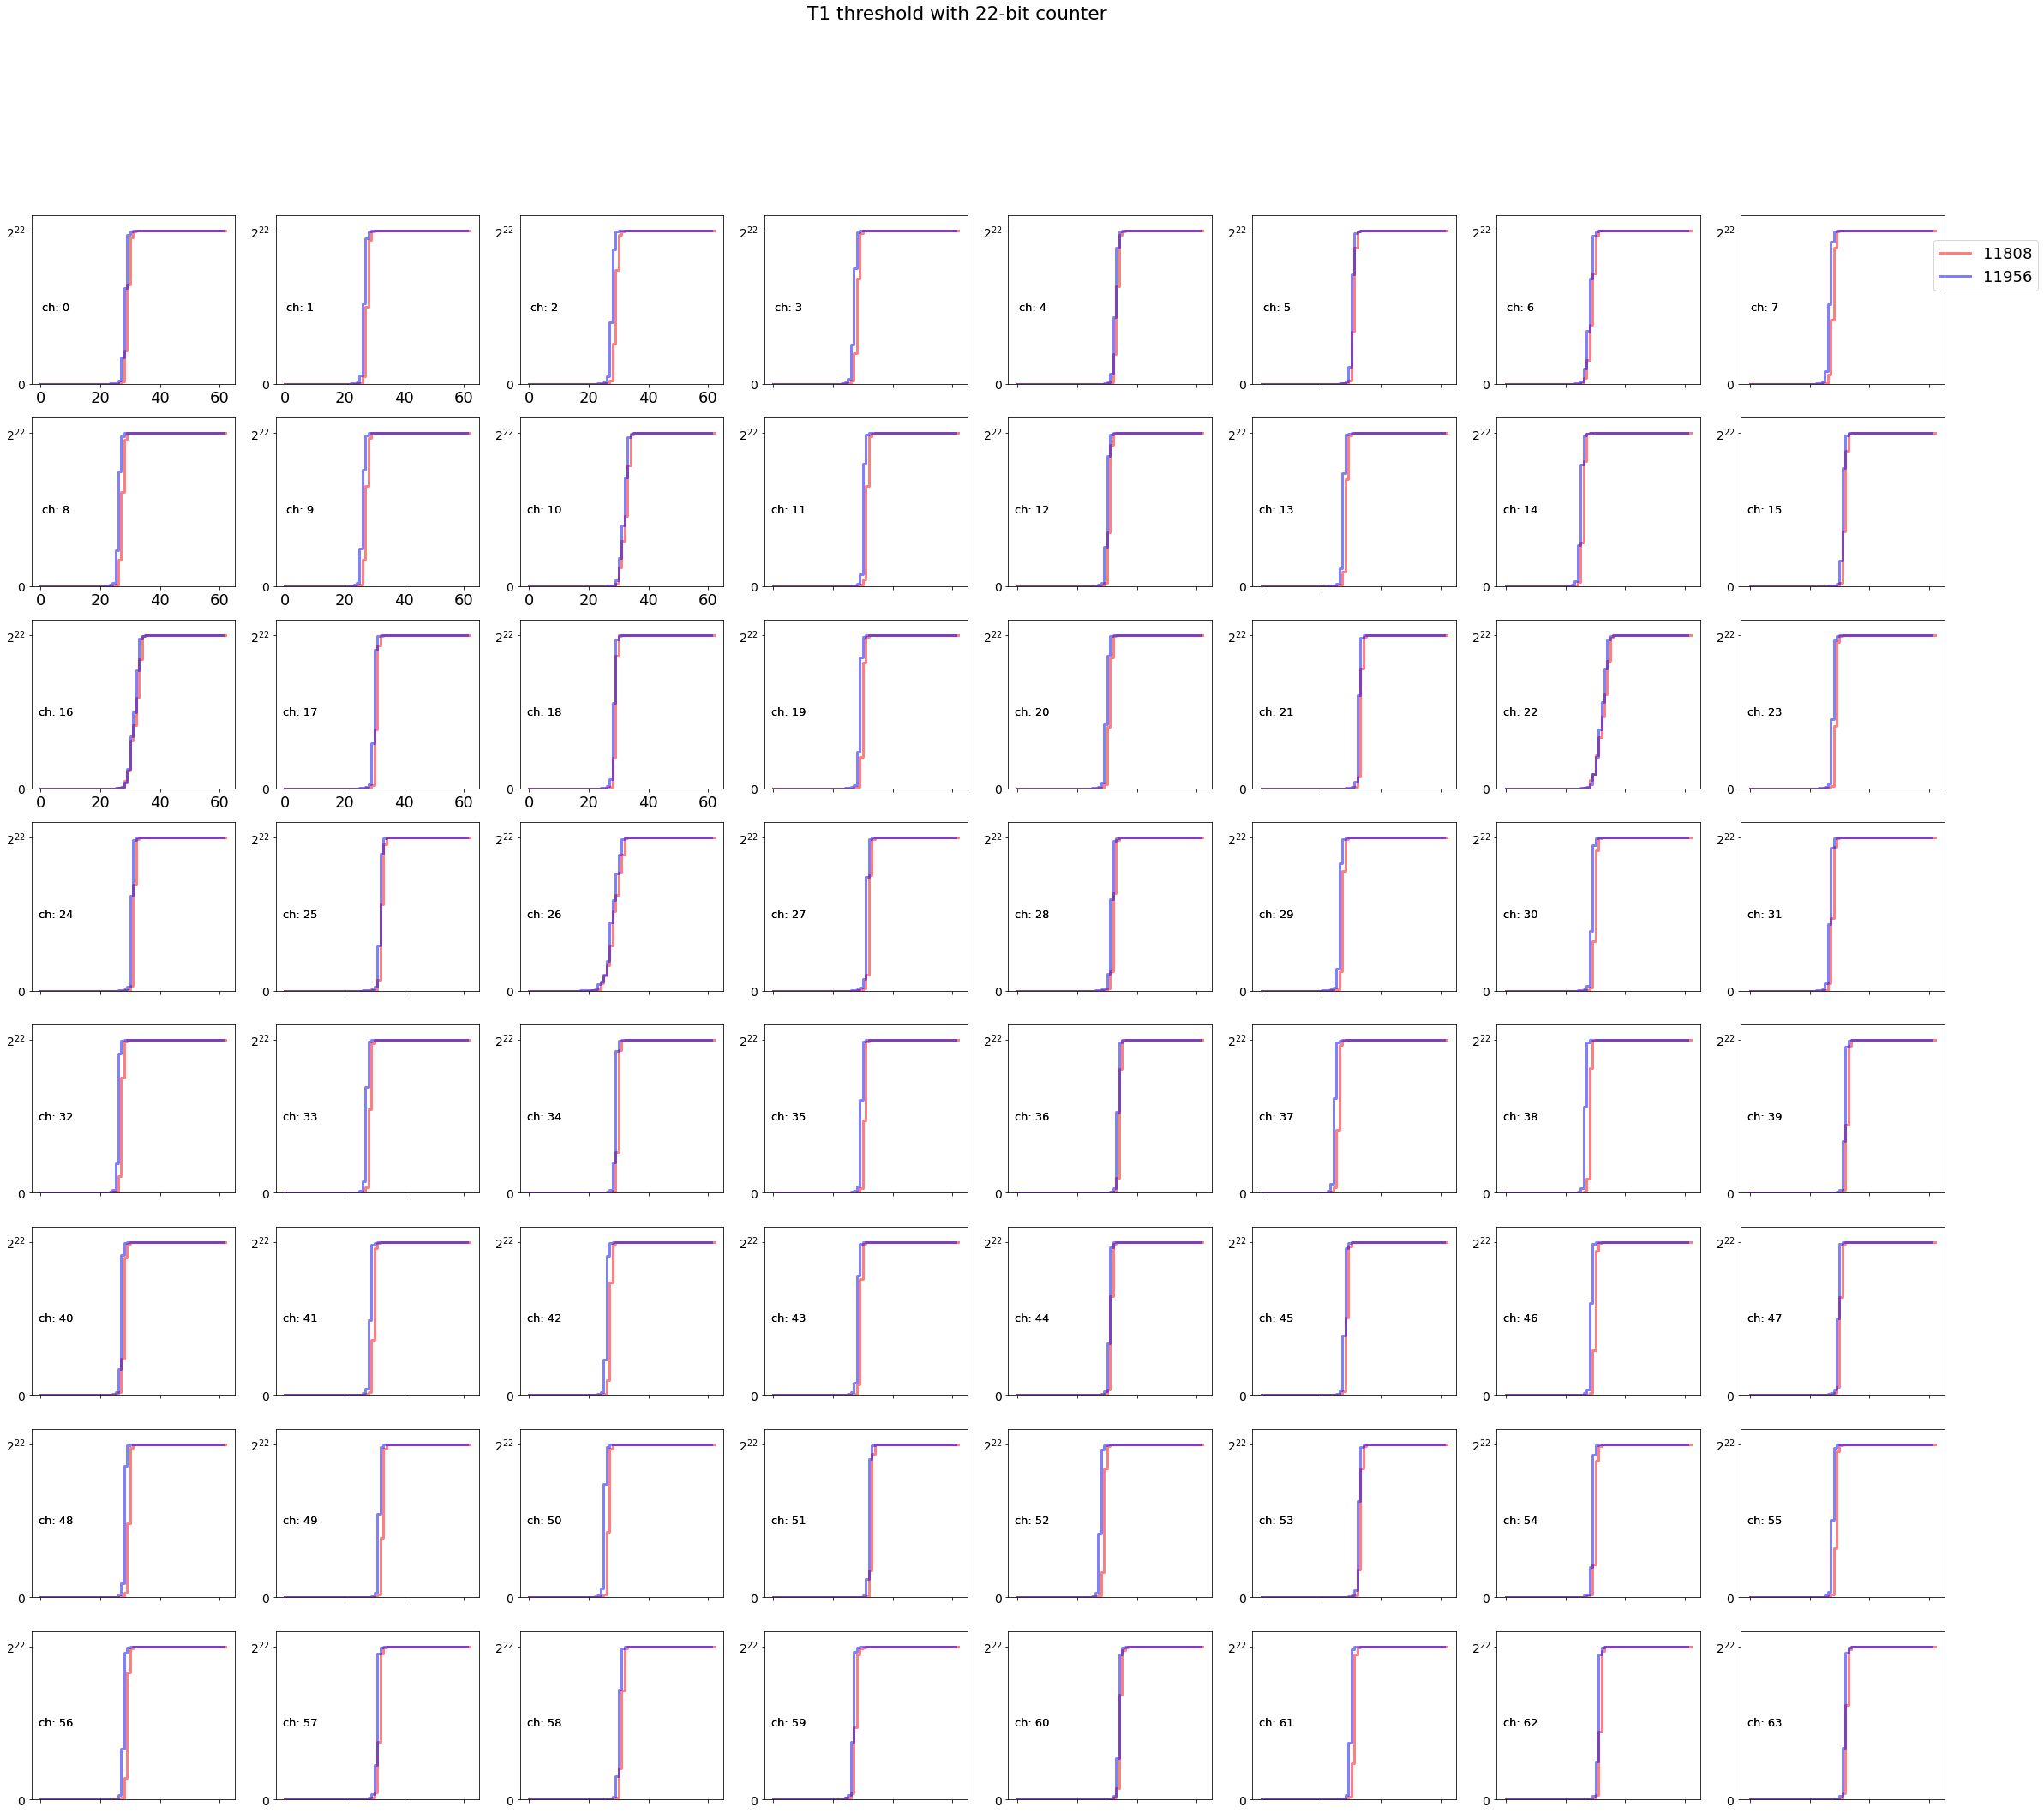

In [21]:
plot_channels_multiple_runs(dfs, runs, channels, title="T1 threshold with 22-bit counter")

# Find threshold vth_t1 and vth_t2

In [29]:
vth_t = find_threshold(df_counts, nbits, field) # if field = vth_t2, 4th argument (activity) is needed 
vth_t

array([23., 18., 29., 20., 14., 16., 16., 20., 18., 19., 19., 22., 26.,
       14., 20., 20., 13., 17., 18., 18., 16., 17., 10., 16., 20., 20.,
        3., 16., 19., 20., 32., 21., 17., 20., 17., 17., 22., 16., 20.,
       22., 17., 17., 16., 15., 18., 20., 14., 14., 20., 20., 21., 17.,
       16., 12., 11., 20., 19., 14., 14.,  5.,  8., 12., 14., 20.])

**Dictionary for data acquisition program:**

In [25]:
ts = {}

for i in range(64):
    ts[i]= int(vth_t[i])

ts

{0: 23,
 1: 18,
 2: 29,
 3: 20,
 4: 14,
 5: 16,
 6: 16,
 7: 20,
 8: 18,
 9: 19,
 10: 19,
 11: 22,
 12: 26,
 13: 14,
 14: 20,
 15: 20,
 16: 13,
 17: 17,
 18: 18,
 19: 18,
 20: 16,
 21: 17,
 22: 10,
 23: 16,
 24: 20,
 25: 20,
 26: 3,
 27: 16,
 28: 19,
 29: 20,
 30: 32,
 31: 21,
 32: 17,
 33: 20,
 34: 17,
 35: 17,
 36: 22,
 37: 16,
 38: 20,
 39: 22,
 40: 17,
 41: 17,
 42: 16,
 43: 15,
 44: 18,
 45: 20,
 46: 14,
 47: 14,
 48: 20,
 49: 20,
 50: 21,
 51: 17,
 52: 16,
 53: 12,
 54: 11,
 55: 20,
 56: 19,
 57: 14,
 58: 14,
 59: 5,
 60: 8,
 61: 12,
 62: 14,
 63: 20}